# FCN

- Fully Convolutional Networks for Semantic Segmentation

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

weights = models.segmentation.FCN_ResNet50_Weights.DEFAULT
label_names = weights.meta["categories"]

model = models.segmentation.fcn_resnet50(weights=weights)
model.eval()
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [2]:
def preprocess_image(image):
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)
    return image


def predict(image_tensor, model):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output

## Prediction

In [3]:
image_path = "dog1.jpg"
image = Image.open(image_path)
image_tensor = preprocess_image(image)

outputs = predict(image_tensor, model)  # dict: {'out', 'aux'}
output = outputs["out"].detach().cpu()
output.size()  # [batch, classes, *segmentation map(scores)]

torch.Size([1, 21, 520, 520])

In [4]:
scores = torch.softmax(output.squeeze(0), dim=0)
classes = scores.argmax(dim=0)

# Ignore background class(0)
unique_classes, counts = torch.unique(classes, return_counts=True)
counts = counts[unique_classes != 0]
unique_classes = unique_classes[unique_classes != 0]


def get_label_name(class_id):
    return label_names[class_id] if class_id < len(label_names) else "Unknown"


for class_id in unique_classes:
    class_scores = scores[class_id]

    # Filter scores with segmentation classes
    is_class = np.isin(classes, [class_id])
    filtered_class_score = np.where(is_class, class_scores, 0)
    # Average of non-zero scores
    mean_score = filtered_class_score[filtered_class_score != 0].mean()

    label = get_label_name(class_id)
    print(f"{label}({class_id}): {mean_score * 100:.2f}")

diningtable(11): 53.90
dog(12): 95.35
person(15): 91.52
sofa(18): 55.33


## Segmentation

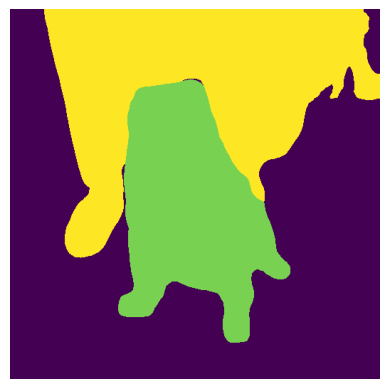

In [5]:
n_class = 2

sorted_indices = torch.argsort(counts, descending=True)
top_classes = unique_classes[sorted_indices[:n_class]]

is_class = np.isin(classes, top_classes)
filtered_mask = np.where(is_class, classes, 0)

plt.imshow(filtered_mask)
plt.axis("off")
plt.show()

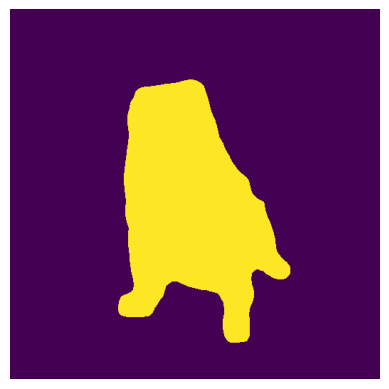

In [6]:
class_id = 12  # dog

is_class = np.isin(classes, [class_id])
filtered_mask = np.where(is_class, 1, 0)

plt.imshow(filtered_mask)
plt.axis("off")
plt.show()

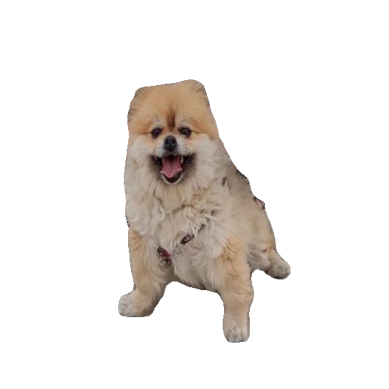

In [7]:
filtered_mask = np.isin(classes, [class_id])
bg_color = 255  # white

img_array = np.array(image.resize((filtered_mask.shape)))
filtered_mask = filtered_mask[:, :, None]  # (520, 520, 1)
filtered_array = np.where(filtered_mask, img_array, bg_color)
masked_image = Image.fromarray(filtered_array)

plt.imshow(masked_image)
plt.axis("off")
plt.show()

## Experiments

Final segmentation map

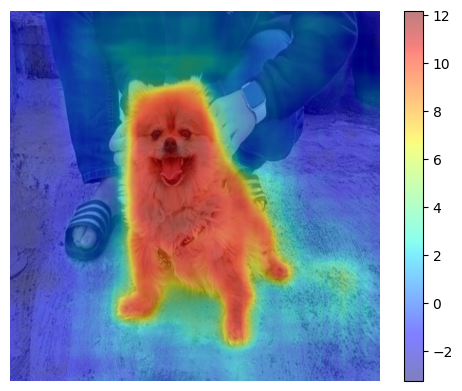

In [8]:
segmentation_map = output.squeeze(0)[class_id].numpy()

plt.imshow(image.resize(segmentation_map.shape))
plt.imshow(segmentation_map, alpha=0.5, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

Intermediate segmentation map with "skip connection"

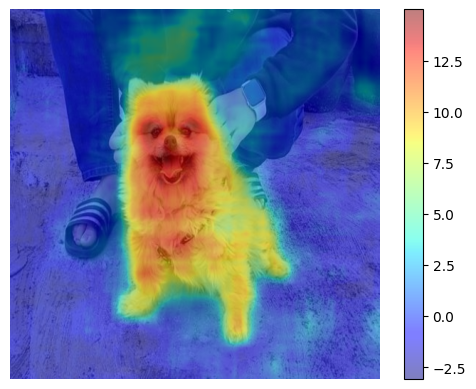

In [9]:
output_aux = outputs["aux"].detach().cpu()
aux_segmentation_map = output_aux.squeeze(0)[class_id].numpy()

plt.imshow(image.resize(aux_segmentation_map.shape))
plt.imshow(aux_segmentation_map, alpha=0.5, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()